# STRd FS neuron model

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [3]:
model = 'aeif_cond_exp'
V_rest = -99.9
V_th = -57.
params = {'C_m': 72.6*0.7,
          'g_L': 4.6*3.9,
          'E_L': V_rest,
          'I_e': -40.,
          'a': 0.,
          'b': 15.,
          'tau_w': 250.,
          'V_th': V_th,
          'Delta_T': 20.,
          'V_reset': -64.6,
          'V_peak': -6.2,
          't_ref': 1.13,
         }

In [4]:
import nest
nest.set_verbosity('M_WARNING')

nest.Install('bgmodule')
model in nest.Models()

True

In [5]:
amps = np.concatenate((np.linspace(-50., 450., 11), np.linspace(460., 660., 11)))
stimuli = [{'delay': 100., 'duration': 1000., 'amp': amp} for amp in amps]

In [6]:
def simulate(time, stim, params, V_init=None):
    nest.ResetKernel()
    nrn = nest.Create(model, params=params)
    mme = nest.Create('multimeter', params={'record_from': ['V_m', 'w']})
    spd = nest.Create('spike_recorder')
    nest.Connect(mme, nrn)
    nest.Connect(nrn, spd)

    if V_init:
        nest.SetStatus(nrn, {'V_m': V_init})
    else:
        nest.SetStatus(nrn, {'V_m': V_rest})
    nest.Simulate(stim['delay'])
    I_e = nest.GetStatus(nrn, 'I_e')[0]
    nest.SetStatus(nrn, {'I_e': I_e + stim['amp']})
    print('I_e=', I_e + stim['amp'])
    nest.Simulate(stim['duration'])
    nest.SetStatus(nrn, {'I_e': I_e})
    nest.Simulate(time - stim['delay'] - stim['duration'])
    
    spikes = nest.GetStatus(spd, keys='events')[0]['times']
    times = nest.GetStatus(mme)[0]['events']['times']
    V_m = nest.GetStatus(mme)[0]['events']['V_m']
    w = nest.GetStatus(mme)[0]['events']['w']
    sweep_data = {'stim_amp': stim['amp'], 
                  'times': times, 
                  'V_m': V_m, 
                  'w': w, 
                  'spikes': spikes}
    return sweep_data

In [7]:
sweeps = [simulate(1000. + 2*stim['delay'], stim, params) for stim in stimuli]

I_e= -90.0
I_e= -40.0
I_e= 10.0
I_e= 60.0
I_e= 110.0
I_e= 160.0
I_e= 210.0
I_e= 260.0
I_e= 310.0
I_e= 360.0
I_e= 410.0
I_e= 420.0
I_e= 440.0
I_e= 460.0
I_e= 480.0
I_e= 500.0
I_e= 520.0
I_e= 540.0
I_e= 560.0
I_e= 580.0
I_e= 600.0
I_e= 620.0


In [8]:
def with_peaks(volts, times, spikes, vpeak=0.0):
    spike_times = list(spikes)
    time_with_spikes = []
    volt_with_peaks = []
    next_spike = spike_times.pop(0) if spike_times else times[-1]
    for volt, time in zip(volts, times):
        if time > next_spike:
            time_with_spikes.append(next_spike)
            volt_with_peaks.append(vpeak)
            next_spike = spike_times.pop(0) if spike_times else times[-1]
        time_with_spikes.append(time)
        volt_with_peaks.append(volt)
    return np.array(time_with_spikes), np.array(volt_with_peaks)

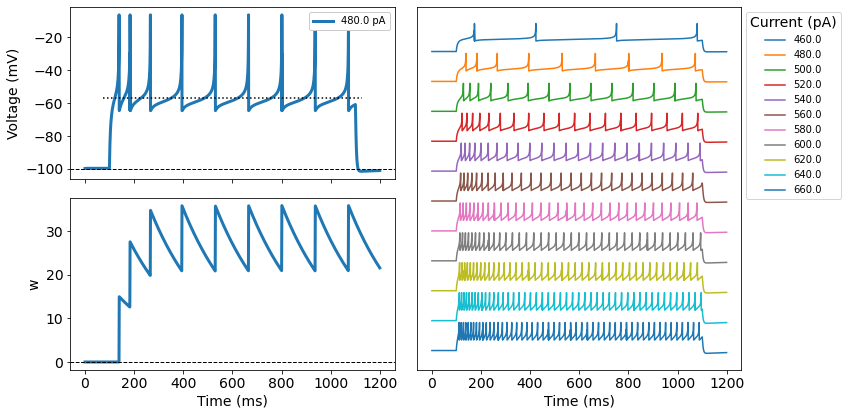

In [9]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(122)
vwplot = 1
for i, sweep in enumerate([x for x in sweeps if len(x['spikes']) > 3]):
    ts = sweep['times']
    vs = sweep['V_m']
    ws = sweep['w']
    tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
    ax3.plot(tp, vp - i*100, label=round(sweep['stim_amp'], 1))
    if i == vwplot:
        ax1.plot(tp, vp, 'tab:blue', lw=3, label=f"{round(sweep['stim_amp'], 1)} pA")
        ax2.plot(ts, ws, 'tab:blue', lw=3)
ax1.axhline(V_rest, c='k', ls='--', lw=1)
ax1.axhline(V_th, xmin=0.1, xmax=0.9, c='k', ls=':')
ax2.axhline(0, c='k', ls='--', lw=1)
ax2.set_xlabel('Time (ms)')
ax3.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax2.set_ylabel('w')
ax3.set_yticks([])
ax1.legend(loc='upper right', fontsize=10, framealpha=1)
ax3.legend(title='Current (pA)', bbox_to_anchor=(1, 1), fontsize=10)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()

In [10]:
currents_iv = [sweep['stim_amp'] for sweep in sweeps if len(sweep['spikes']) == 0]
volts_iv = [sweep['V_m'][1090] for sweep in sweeps if len(sweep['spikes']) == 0]
currents = [sweep['stim_amp'] for sweep in sweeps if len(sweep['spikes']) > 1]
rates_ini = np.array([1e3 / (sweep['spikes'][1] - sweep['spikes'][0]) 
             for sweep in sweeps if len(sweep['spikes']) > 1])
rates_avg = np.array([1e3 * len(sweep['spikes']) / stimuli[0]['duration']
             for sweep in sweeps if len(sweep['spikes']) > 1])
adapt = rates_avg / rates_ini

In [11]:
import json
spec = json.load(open('expdata/161205_FS1-spec.json'))

In [12]:
exp_stimuli_iv = [stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IV']]
exp_volts_iv = [feat['steady_state_voltage_stimend'][0] for stim, feat in spec['cell_features']['IV']]
exp_stimuli = [stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IDthresh']]
exp_rates_ini = np.array([feat['inv_first_ISI'][0] for stim, feat in spec['cell_features']['IDthresh']])
exp_rates_avg = np.array([feat['mean_frequency'][0] for stim, feat in spec['cell_features']['IDthresh']])
exp_adapt = exp_rates_avg / exp_rates_ini

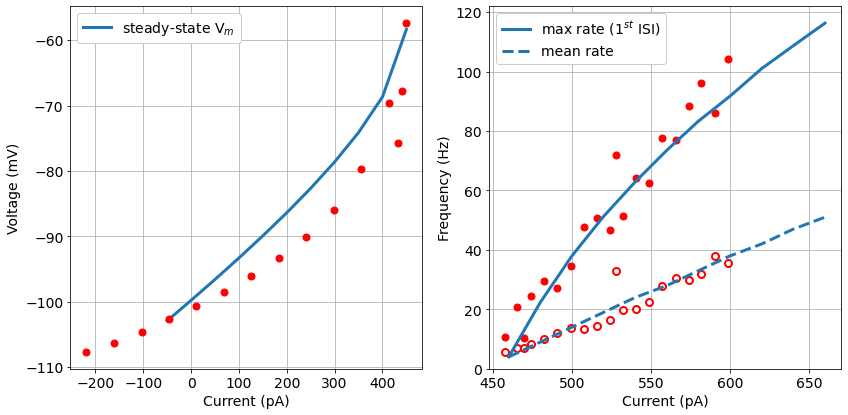

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(currents_iv, volts_iv, lw=3, label='steady-state V$_m$')
ax1.plot(exp_stimuli_iv, exp_volts_iv, 'ro', markersize=7)
ax1.plot([stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IDthresh-sub']],
         [feat['steady_state_voltage_stimend'][0] for stim, feat in spec['cell_features']['IDthresh-sub']],
         'ro', markersize=7)

ax1.legend(framealpha=1)
ax1.grid()
ax1.set_xlabel('Current (pA)')
ax1.set_ylabel('Voltage (mV)')

ax2.plot(exp_stimuli, exp_rates_ini, 'ro', markersize=7)
ax2.plot(exp_stimuli, exp_rates_avg, 'ro', markersize=7, markerfacecolor='w', markeredgewidth=2)

ax2.plot([stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IV-supra']], 
        np.array([feat['inv_first_ISI'][0] for stim, feat in spec['cell_features']['IV-supra']]),
        'ro', markersize=7)
ax2.plot([stim['stimulus_total_amp'] for stim, feat in spec['cell_features']['IV-supra']], 
        np.array([feat['mean_frequency'][0] for stim, feat in spec['cell_features']['IV-supra']]), 
        'ro', markersize=7, markerfacecolor='w', markeredgewidth=2)

ax2.plot(currents, rates_ini, linewidth=3, c='tab:blue', label='max rate (1$^{st}$ ISI)')
ax2.plot(currents, rates_avg, linewidth=3, c='tab:blue', ls='--', label='mean rate')

ax2.legend(framealpha=1)
ax2.set_ylim(0)
ax2.grid()
ax2.set_xlabel('Current (pA)')
ax2.set_ylabel('Frequency (Hz)')
fig.tight_layout()

In [14]:
import pandas
pandas.DataFrame(zip(exp_stimuli, exp_rates_ini, exp_rates_avg, exp_adapt),
                 columns=['stim', 'f_1', 'f_mean', 'adapt'])

,stim,f_1,f_mean,adapt
0,457.639413,10.775862,5.606953,0.520325
1,465.483274,20.876827,6.832037,0.327255
2,473.788627,24.630542,8.308833,0.337339
3,482.439028,29.585799,10.191948,0.344488
4,490.765351,27.027027,11.890606,0.439952
5,499.598980,34.722222,13.604071,0.391797
6,507.332179,47.846890,13.553536,0.283269
7,515.626094,50.761421,14.522375,0.286091
8,523.955229,46.728972,16.565138,0.354494
9,532.339804,51.546392,19.691003,0.382005


In [15]:
pandas.DataFrame(zip(currents, rates_ini, rates_avg, adapt), columns=['stim', 'f_1', 'f_mean', 'adapt'])

,stim,f_1,f_mean,adapt
0,460.0,4.004806,4.0,0.9988
1,480.0,22.371365,9.0,0.4023
2,500.0,38.022814,14.0,0.3682
3,520.0,51.282051,19.0,0.3705
4,540.0,62.893082,24.0,0.3816
5,560.0,73.529412,28.0,0.3808
6,580.0,83.333333,33.0,0.3960
7,600.0,91.743119,38.0,0.4142
8,620.0,101.010101,42.0,0.4158
9,640.0,108.695652,47.0,0.4324


In [16]:
amps = np.linspace(-161., 527., 9)
stimuli2 = [{'delay': 100., 'duration': 1000., 'amp': amp} for amp in amps]

In [17]:
params2 = params.copy()
sweeps2 = [simulate(1400., stim, params2) for stim in stimuli2]

I_e= -201.0
I_e= -115.0
I_e= -29.0
I_e= 57.0
I_e= 143.0
I_e= 229.0
I_e= 315.0
I_e= 401.0
I_e= 487.0


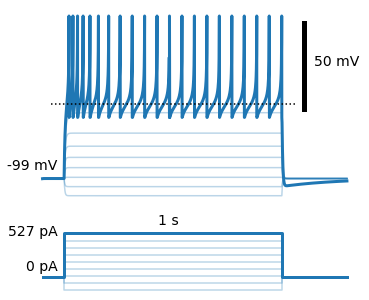

In [18]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

tc = [0., 100., 100., 1100., 1100, 1400.]
for sweep in sweeps2[:-1]:
    ts = sweep['times']
    vs = sweep['V_m']
    tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
    ax1.plot(tp, vp, 'tab:blue', alpha=0.3)
    dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
    ax2.plot(tc, dc, 'tab:blue', alpha=0.3)
sweep = sweeps2[-1]
ts = sweep['times']
vs = sweep['V_m']
tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
ax1.plot(tp, vp, 'tab:blue', lw=3)
dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
ax2.plot(tc, dc, 'tab:blue', lw=3)

ax1.plot([1200, 1200], [-10, -60], 'k', linewidth=5)
ax1.axhline(V_th, xmin=0.07, xmax=0.8, c='k', ls=':')

ax1.annotate('50 mV', xy=(1250, -35), xycoords='data')
ax1.annotate('-99 mV', xy=(70, -95), xycoords='data', ha='right')
ax2.annotate('527 pA', xy=(70, 500), xycoords='data', ha='right')
ax2.annotate('0 pA', xy=(70, 70), xycoords='data', ha='right')
ax2.annotate('1 s', xy=(0.42, 1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');

In [19]:
amps = np.linspace(-344., 344., 9)
stimuli2 = [{'delay': 100., 'duration': 1000., 'amp': amp} for amp in amps]

In [20]:
params2 = params.copy()
params2['I_e'] = params['I_e'] + 183.
sweeps2 = [simulate(1400., stim, params2, V_init=-87.6) for stim in stimuli2]

I_e= -201.0
I_e= -115.0
I_e= -29.0
I_e= 57.0
I_e= 143.0
I_e= 229.0
I_e= 315.0
I_e= 401.0
I_e= 487.0


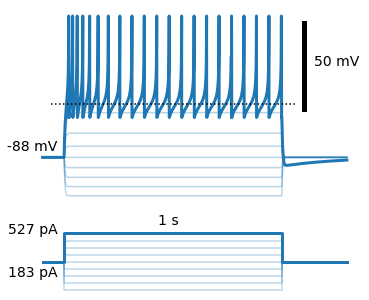

In [21]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

tc = [0., 100., 100., 1100., 1100, 1400.]
for sweep in sweeps2[:-1]:
    ts = sweep['times']
    vs = sweep['V_m']
    tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
    ax1.plot(tp, vp, 'tab:blue', alpha=0.3)
    dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
    ax2.plot(tc, dc, 'tab:blue', alpha=0.3)
sweep = sweeps2[-1]
ts = sweep['times']
vs = sweep['V_m']
tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
ax1.plot(tp, vp, 'tab:blue', lw=3)
dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
ax2.plot(tc, dc, 'tab:blue', lw=3)

ax1.plot([1200, 1200], [-10, -60], 'k', linewidth=5)
ax1.axhline(V_th, xmin=0.07, xmax=0.8, c='k', ls=':')
ax1.annotate('50 mV', xy=(1250, -35), xycoords='data')
ax1.annotate('-88 mV', xy=(70, -84), xycoords='data', ha='right')
ax2.annotate('527 pA', xy=(70, 344), xycoords='data', ha='right')
ax2.annotate('183 pA', xy=(70, -180), xycoords='data', ha='right')
ax2.annotate('1 s', xy=(0.42, 1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');

Below cell fires faster due to the voltage drift. This trace was not used for fitting.

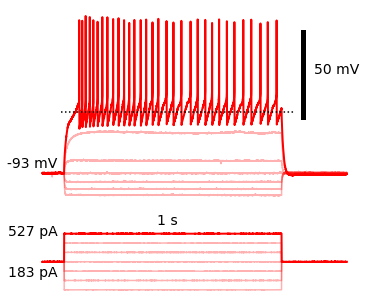

In [22]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

for i in range(584, 596, 2):
    te, ve = np.loadtxt(f'expdata/161205_FS1/ECall_IV_ch3_{i}.dat').T
    ax1.plot(te, ve - 11.5, 'red', alpha=0.3)
    te, ce = np.loadtxt(f'expdata/161205_FS1/ECall_IV_ch2_{i}.dat').T
    ax2.plot(te, ce, 'red', alpha=0.3)
i = 596
te, ve = np.loadtxt(f'expdata/161205_FS1/ECall_IV_ch3_{i}.dat').T
ax1.plot(te, ve - 11.5, 'red', lw=2)
ax1.axhline(V_th, xmin=0.1, xmax=0.8, c='k', ls=':')
te, ce = np.loadtxt(f'expdata/161205_FS1/ECall_IV_ch2_{i}.dat').T
ax2.plot(te, ce, 'red', lw=2)
ax1.plot([1200, 1200], [-10, -60], 'k', linewidth=5)
ax1.annotate('50 mV', xy=(1250, -35), xycoords='data')
ax1.annotate('-93 mV', xy=(70, -90), xycoords='data', ha='right')
ax2.annotate('527 pA', xy=(70, 500), xycoords='data', ha='right')
ax2.annotate('183 pA', xy=(70, -0), xycoords='data', ha='right')
ax2.annotate('1 s', xy=(0.42,1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');

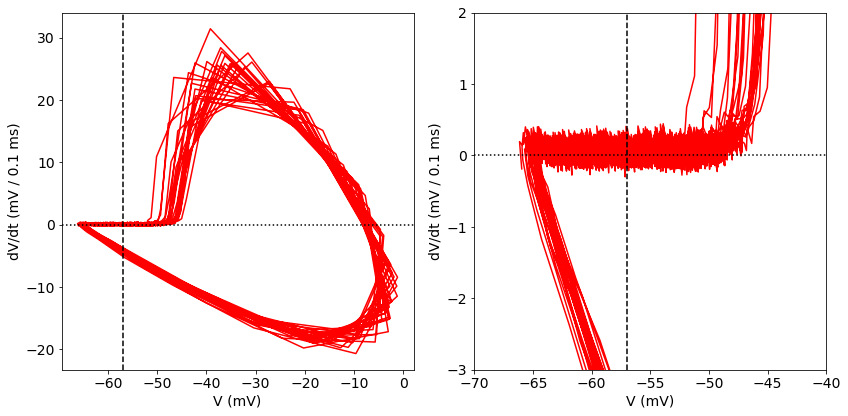

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
vthresh = -57.
vv = ve - 11.5
dv = np.array([y-x for x, y in zip(ve[:-1], ve[1:])])
ax1.plot(vv[2000:-4000-1], dv[2000:-4000], 'r')
ax1.axvline(vthresh, c='k', ls='--')
ax1.axhline(0, c='k', ls=':')
ax2.plot(vv[2000:-4000-1], dv[2000:-4000], 'r')
ax2.axvline(vthresh, c='k', ls='--')
ax2.set_xlim(-70, -40), ax2.set_ylim(-3., 2)
ax2.axhline(0, c='k', ls=':')
ax1.set_xlabel('V (mV)'), ax1.set_ylabel('dV/dt (mV / 0.1 ms)')
ax2.set_xlabel('V (mV)'), ax2.set_ylabel('dV/dt (mV / 0.1 ms)')
fig.tight_layout()

In [24]:
amps = np.linspace(249., 341., 3)
stimuli2 = [{'delay': 700., 'duration': 2000., 'amp': amp} for amp in amps]

In [25]:
params2 = params.copy()
params2['I_e'] = params['I_e'] + 183.
sweeps2 = [simulate(3000., stim, params2, V_init=-87.6) for stim in stimuli2]

I_e= 392.0
I_e= 438.0
I_e= 484.0


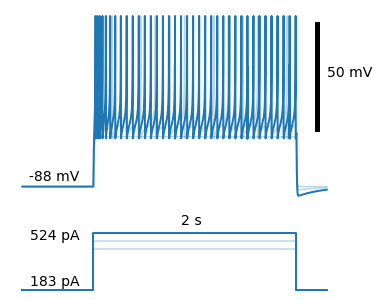

In [26]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

tc = [0., 700., 700., 2700., 2700, 3000.]
for sweep in sweeps2[:-1]:
    ts = sweep['times']
    vs = sweep['V_m']
    tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
    ax1.plot(tp, vp, 'tab:blue', alpha=0.3)
    dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
    ax2.plot(tc, dc, 'tab:blue', alpha=0.3)
sweep = sweeps2[-1]
ts = sweep['times']
vs = sweep['V_m']
tp, vp = with_peaks(vs, ts, sweep['spikes'], params['V_peak'])
ax1.plot(tp, vp, 'tab:blue', lw=2)
dc = [0., 0., sweep['stim_amp'], sweep['stim_amp'], 0., 0.]
ax2.plot(tc, dc, 'tab:blue', lw=2)

ax1.plot([2900, 2900], [-10, -60], 'k', linewidth=5)
ax1.annotate('50 mV', xy=(3000, -35), xycoords='data')
ax1.annotate('-88 mV', xy=(70, -85), xycoords='data', ha='left')
ax2.annotate('524 pA', xy=(70, 300), xycoords='data', ha='left')
ax2.annotate('183 pA', xy=(70, 25), xycoords='data', ha='left')
ax2.annotate('2 s', xy=(0.55, 1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');

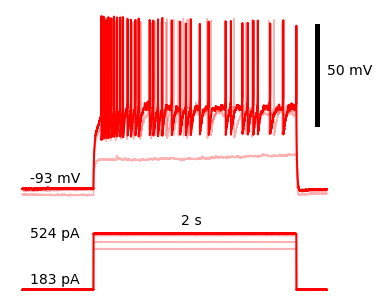

In [27]:
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(614)

for i in range(713, 724, 5):
    te, ve = np.loadtxt(f'expdata/161205_FS1/ECall_IDthresh_ch3_{i}.dat').T
    ax1.plot(te, ve - 11.5, 'red', alpha=0.3)
    te, ce = np.loadtxt(f'expdata/161205_FS1/ECall_IDthresh_ch2_{i}.dat').T
    ax2.plot(te, ce, 'red', alpha=0.3)
i = 724
te, ve = np.loadtxt(f'expdata/161205_FS1/ECall_IDthresh_ch3_{i}.dat').T
ax1.plot(te, ve - 11.5, 'red', lw=2)
te, ce = np.loadtxt(f'expdata/161205_FS1/ECall_IDthresh_ch2_{i}.dat').T
ax2.plot(te, ce, 'red', lw=2)
ax1.plot([2900, 2900], [-10, -60], 'k', linewidth=5)
ax1.annotate('50 mV', xy=(3000, -35), xycoords='data')
ax1.annotate('-93 mV', xy=(70, -90), xycoords='data', ha='left')
ax2.annotate('524 pA', xy=(70, 500), xycoords='data', ha='left')
ax2.annotate('183 pA', xy=(70, 220), xycoords='data', ha='left')
ax2.annotate('2 s', xy=(0.55, 1.1), xycoords='axes fraction', ha='center')
ax1.axis('off'), ax2.axis('off');